In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [3]:
def prepare_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.pct_change().dropna()  # Convert to returns
    return df

In [4]:
def risk_aversion_from_percentage(risk_tolerance_percent):
    """
    Convert 1–100 risk tolerance scale to risk aversion lambda.
    Higher tolerance = lower lambda (more aggressive).
    """
    # Scale from ~0.01 (aggressive) to ~100 (very conservative)
    min_lambda = 0.01
    max_lambda = 100
    scaled = 1 - (risk_tolerance_percent / 100)  # 100% risk tolerance → lambda near 0
    lam = min_lambda + scaled * (max_lambda - min_lambda)
    return lam

In [5]:
def optimize_portfolio(returns, risk_tolerance):
    mu = returns.mean().values
    Sigma = returns.cov().values
    n_assets = len(mu)

    w = cp.Variable(n_assets)

    lam = risk_aversion_from_percentage(risk_tolerance)

    # Normalize for better numerical behavior
    mu_norm = mu / np.linalg.norm(mu)
    Sigma_norm = Sigma / np.linalg.norm(Sigma)

    objective = cp.Maximize(mu_norm @ w - lam * cp.quad_form(w, Sigma_norm))
    constraints = [cp.sum(w) == 1, w >= 0]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status != 'optimal':
        raise ValueError("Optimization failed")

    weights = w.value
    return dict(zip(returns.columns, weights))

In [6]:
def backtest_portfolio(returns, weights, benchmark_col="S&P 500"):
    weights_array = np.array([weights[col] for col in returns.columns])
    portfolio_returns = returns @ weights_array

    cumulative_portfolio = (1 + portfolio_returns).cumprod()
    cumulative_benchmark = (1 + returns[benchmark_col]).cumprod()

    # Performance Metrics
    sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    max_drawdown = (cumulative_portfolio / cumulative_portfolio.cummax() - 1).min()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_portfolio, label="Optimized Portfolio")
    plt.plot(cumulative_benchmark, label=benchmark_col)
    plt.title("Backtest: Portfolio vs. Benchmark")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Results
    return {
        "Cumulative Return (%)": (cumulative_portfolio[-1] - 1) * 100,
        "Annualized Volatility (%)": portfolio_returns.std() * np.sqrt(252) * 100,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown * 100
    }

In [7]:
def run_optimizer_and_backtest(df, user_inputs):
    returns = prepare_data(df)
    weights = optimize_portfolio(returns, risk_tolerance=user_inputs["risk_tolerance"])
    performance = backtest_portfolio(returns, weights, benchmark_col="S&P 500")

    print("Optimal Portfolio Weights:")
    for asset, weight in weights.items():
        print(f"{asset}: {weight:.2%}")

    print("\nPerformance Metrics:")
    for k, v in performance.items():
        print(f"{k}: {v:.2f}")

    return weights, performance

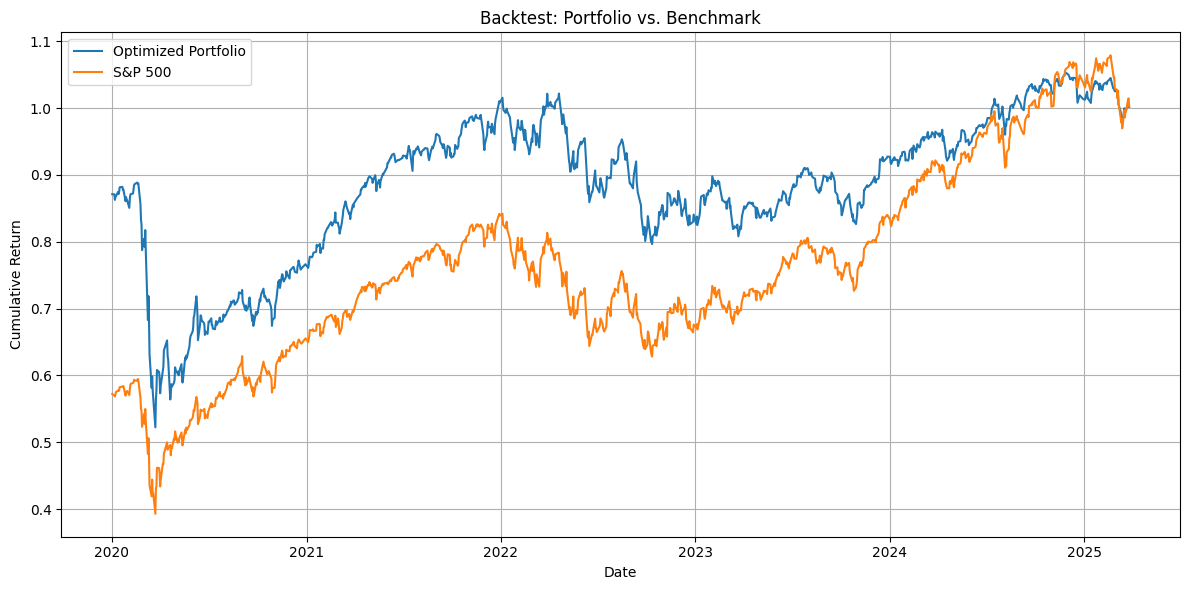

Optimal Portfolio Weights:
Treasury Yield 30 Years: 7.56%
FTSE NAREIT All Equity REITs Index: 40.01%
S&P 500: 43.08%
BTC: 0.00%
WTI Oil: 9.35%

Performance Metrics:
Cumulative Return (%): -12.87
Annualized Volatility (%): 22.31
Sharpe Ratio: -0.04
Max Drawdown (%): -50.42


<ipython-input-6-182f2161e757>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Cumulative Return (%)": (cumulative_portfolio[-1] - 1) * 100,


In [12]:
if __name__ == "__main__":
    # Load your dataset
    df = pd.read_excel("/content/drive/MyDrive/FinHack/1.xlsx")  # Replace with your actual file

    # User Preferences
    user_inputs = {
        "risk_tolerance": 80,
    }
    run_optimizer_and_backtest(df, user_inputs)